<a href="https://colab.research.google.com/github/atrabaja/MachineLearning_FinMark/blob/main/MS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [359]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [360]:
import os
data_path = '/content/drive/MyDrive'

In [362]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [363]:
# Define file paths
customers_file_path = '/content/drive/My Drive/customers_data.csv'
products_file_path = '/content/drive/My Drive/products_data.csv'
transactions_file_path = '/content/drive/My Drive/transactions_data.csv'

In [364]:
# Load datasets
customers_data = pd.read_csv(customers_file_path)
products_data = pd.read_csv(products_file_path)
transactions_data = pd.read_csv(transactions_file_path)

# Display the first few rows of each dataset
print(customers_data.head())
print(products_data.head())
print(transactions_data.head())

   Company_ID          Company_Name  Company_Profit  \
0         1.0  Tech  Enterprises  1         80701.0   
1         2.0   Global  Partners  2         80511.0   
2         3.0  Quantum Associates 3        110664.0   
3         4.0       Prime Network 4             NaN   
4         5.0    Elite  Ventures  5         69427.0   

                                             Address  
0             EDSA, Barangay 606, Pasig, Philippines  
1  Commonwealth Ave, Barangay 789, Taguig, Philip...  
2       Roxas Blvd, Barangay 505, Pasig, Philippines  
3  Alabang-Zapote Rd, Barangay 202, Taguig, Phili...  
4    Ayala Avenue, Barangay 101, Makati, Philippines  
   Product_ID            Product_Name Product_Price
0         1.0      FinPredictor Suite      ?140,000
1         2.0  MarketMinder Analytics      ?168,000
2         3.0    TrendWise Forecaster      ?100,800
3         4.0  CustomerScope Insights      ?123,200
4         5.0     SalesSync Optimizer       ?84,000
   Unnamed: 0  Transaction_

In [365]:
# Preprocessing Customers Data
# Identify rows with missing Company_ID
missing_ids = customers_data[customers_data['Company_ID'].isnull()]

# Map existing Company_IDs to rows with missing IDs based on matching columns
customers_data['Company_ID'] = customers_data['Company_ID'].fillna(
    customers_data.merge(
        customers_data[['Company_ID', 'Company_Name', 'Address', 'Company_Profit']].dropna(subset=['Company_ID']),
        on=['Company_Name', 'Address', 'Company_Profit'],
        how='left'
    )['Company_ID_y']
)

In [366]:
# Find the maximum existing Company_ID
max_id = customers_data['Company_ID'].max()

# Assign unique IDs to remaining missing rows
customers_data.loc[customers_data['Company_ID'].isnull(), 'Company_ID'] = range(
    int(max_id) + 1, int(max_id) + 1 + customers_data['Company_ID'].isnull().sum()
)

# Convert Company_ID to integer type
customers_data['Company_ID'] = customers_data['Company_ID'].astype(int)

In [367]:
# Check for duplicates based on Company_Name, Address, and Company_Profit
duplicates = customers_data[customers_data.duplicated(subset=['Company_Name', 'Address', 'Company_Profit'], keep=False)]
print(duplicates)

# Drop duplicates if necessary
customers_data = customers_data.drop_duplicates(subset=['Company_Name', 'Address', 'Company_Profit'], keep='first')

Empty DataFrame
Columns: [Company_ID, Company_Name, Company_Profit, Address]
Index: []


In [368]:
# Verify there are no missing values or duplicates
print(customers_data.isnull().sum())
print(customers_data.duplicated().sum())

# Display dataset summary
print(customers_data.info())
print(customers_data.head())

Company_ID         0
Company_Name       0
Company_Profit    12
Address            0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_ID      100 non-null    int64  
 1   Company_Name    100 non-null    object 
 2   Company_Profit  88 non-null     float64
 3   Address         100 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.3+ KB
None
   Company_ID          Company_Name  Company_Profit  \
0           1  Tech  Enterprises  1         80701.0   
1           2   Global  Partners  2         80511.0   
2           3  Quantum Associates 3        110664.0   
3           4       Prime Network 4             NaN   
4           5    Elite  Ventures  5         69427.0   

                                             Address  
0             EDSA, Barangay 606, Pasig, Philippines  
1  Commonwealth Ave,

In [369]:
# Remove numbers from the Company_Name column
customers_data['Company_Name'] = customers_data['Company_Name'].str.replace(r'\d+', '', regex=True).str.strip()

# Verify the changes
print(customers_data['Company_Name'].head())

0     Tech  Enterprises
1      Global  Partners
2    Quantum Associates
3         Prime Network
4       Elite  Ventures
Name: Company_Name, dtype: object


In [370]:
# Fill missing Company_Profit based on Address group median
customers_data['Company_Profit'] = customers_data.groupby('Address')['Company_Profit'].transform(
    lambda x: x.fillna(x.median())
)

In [371]:
# Verify no missing values remain
print(customers_data.isnull().sum())

# Display updated dataset
print(customers_data.head())

Company_ID         0
Company_Name       0
Company_Profit    12
Address            0
dtype: int64
   Company_ID        Company_Name  Company_Profit  \
0           1   Tech  Enterprises         80701.0   
1           2    Global  Partners         80511.0   
2           3  Quantum Associates        110664.0   
3           4       Prime Network             NaN   
4           5     Elite  Ventures         69427.0   

                                             Address  
0             EDSA, Barangay 606, Pasig, Philippines  
1  Commonwealth Ave, Barangay 789, Taguig, Philip...  
2       Roxas Blvd, Barangay 505, Pasig, Philippines  
3  Alabang-Zapote Rd, Barangay 202, Taguig, Phili...  
4    Ayala Avenue, Barangay 101, Makati, Philippines  


In [372]:
# Cleaned customer data
customers_data.to_csv('/content/drive/MyDrive/cleaned_customers_data.csv', index=False)

In [373]:
# Preprocessing Transactions Data
# Check basic info
print(transactions_data.info())
print(transactions_data.head())

# Check for missing values
print(transactions_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        9000 non-null   float64
 1   Transaction_ID    9000 non-null   float64
 2   Company_ID        9000 non-null   float64
 3   Product_ID        9000 non-null   float64
 4   Quantity          9000 non-null   float64
 5   Transaction_Date  10000 non-null  object 
 6   Product_Price     9000 non-null   float64
 7   Total_Cost        9000 non-null   float64
dtypes: float64(7), object(1)
memory usage: 625.1+ KB
None
   Unnamed: 0  Transaction_ID  Company_ID  Product_ID  Quantity  \
0         0.0             1.0        88.0         6.0       NaN   
1         1.0             2.0        29.0        19.0      16.0   
2         2.0             NaN        28.0        18.0       6.0   
3         3.0             4.0        85.0        12.0      12.0   
4         4.0             5.0

In [374]:
# Dropped unnamed column
transactions_data = transactions_data.drop(columns=['Unnamed: 0'])

In [375]:
# Handle missing values in Quantity and ensure it's a whole number
transactions_data['Quantity'] = transactions_data['Quantity'].fillna(transactions_data['Quantity'].median())
transactions_data['Quantity'] = transactions_data['Quantity'].astype(int)  # Convert to whole number

In [376]:
# Handle missing values in Product_Price and ensure it's in two decimal places
transactions_data['Product_Price'] = transactions_data['Product_Price'].fillna(transactions_data['Product_Price'].median())
transactions_data['Product_Price'] = transactions_data['Product_Price'].round(2)  # Round to 2 decimal places

In [378]:
# Display unique formats in Transaction_Date
print("Unique formats in Transaction_Date before conversion:\n", transactions_data['Transaction_Date'].unique())

# Define a function to parse different date formats
def parse_date(date_str):
    # Attempt to parse several known formats
    for fmt in ('%Y-%m-%d', '%d-%m-%Y', '%m-%d-%Y', '%Y/%m/%d', '%d/%m/%Y', '%m/%d/%Y', '%B %d, %Y', '%d %B %Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except (ValueError, TypeError):
            continue  # Try the next format if this one fails
    return pd.NaT  # Return NaT if no formats worked

# Apply the parsing function
transactions_data['Transaction_Date'] = transactions_data['Transaction_Date'].apply(parse_date)

# Check for NaT values after parsing
nat_count = transactions_data['Transaction_Date'].isna().sum()
print("NaT values in Transaction_Date column after conversion:", nat_count)

# Inspect problematic entries if there are any NaT values
if nat_count > 0:
    print("Remaining problematic date entries:\n", transactions_data[transactions_data['Transaction_Date'].isna()]['Transaction_Date'])

# Confirm the data type of Transaction_Date after all conversions
print("Data type of Transaction_Date after final conversion:", transactions_data['Transaction_Date'].dtypes)

Unique formats in Transaction_Date before conversion:
 <DatetimeArray>
['2024-03-26 00:00:00', '2024-07-09 00:00:00', '2024-04-13 00:00:00',
 '2023-06-09 00:00:00', '2021-06-07 00:00:00', '2021-07-12 00:00:00',
 '2023-11-01 00:00:00', '2023-10-31 00:00:00', '2024-02-25 00:00:00',
 '2021-03-29 00:00:00',
 ...
 '2022-11-30 00:00:00', '2024-03-16 00:00:00', '2020-06-11 00:00:00',
 '2020-01-12 00:00:00', '2022-07-13 00:00:00', '2024-11-08 00:00:00',
 '2024-12-04 00:00:00', '2023-11-04 00:00:00', '2020-03-12 00:00:00',
 '2024-12-09 00:00:00']
Length: 1490, dtype: datetime64[ns]
NaT values in Transaction_Date column after conversion: 0
Data type of Transaction_Date after final conversion: datetime64[ns]


In [379]:
# Final check of the dataset
print(transactions_data.info())
print(transactions_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction_ID    9000 non-null   float64       
 1   Company_ID        9000 non-null   float64       
 2   Product_ID        9000 non-null   float64       
 3   Quantity          10000 non-null  int64         
 4   Transaction_Date  10000 non-null  datetime64[ns]
 5   Product_Price     10000 non-null  float64       
 6   Total_Cost        9000 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 547.0 KB
None
   Transaction_ID  Company_ID  Product_ID  Quantity Transaction_Date  \
0             1.0        88.0         6.0        11       2024-03-26   
1             2.0        29.0        19.0        16       2024-07-09   
2             NaN        28.0        18.0         6       2024-04-13   
3             4.0        85.0        12.0  

In [380]:
# Verify Missing Values
print(transactions_data.isnull().sum())

Transaction_ID      1000
Company_ID          1000
Product_ID          1000
Quantity               0
Transaction_Date       0
Product_Price          0
Total_Cost          1000
dtype: int64


In [381]:
# Identify rows with missing Transaction_ID
missing_transaction_ids = transactions_data[transactions_data['Transaction_ID'].isnull()]
print(missing_transaction_ids)

      Transaction_ID  Company_ID  Product_ID  Quantity Transaction_Date  \
2                NaN        28.0        18.0         6       2024-04-13   
17               NaN        57.0        10.0         6       2022-07-10   
21               NaN        25.0        18.0         2       2021-03-21   
25               NaN        93.0         9.0        11       2021-09-21   
55               NaN         NaN        11.0        16       2023-03-08   
...              ...         ...         ...       ...              ...   
9981             NaN         NaN         5.0        11       2022-03-29   
9984             NaN        93.0        19.0        11       2021-03-25   
9995             NaN         NaN        10.0        11       2022-06-05   
9997             NaN        90.0         1.0        15       2022-07-19   
9999             NaN        77.0        16.0        14       2023-10-29   

      Product_Price  Total_Cost  
2         126095.55    940800.0  
17        131297.78    627200.0

In [382]:
# Assign unique identifiers
# Find the maximum existing Transaction_ID
max_transaction_id = transactions_data['Transaction_ID'].max()

# Assign unique IDs to missing Transaction_IDs
transactions_data.loc[transactions_data['Transaction_ID'].isnull(), 'Transaction_ID'] = range(
    int(max_transaction_id) + 1,
    int(max_transaction_id) + 1 + transactions_data['Transaction_ID'].isnull().sum()
)

# Convert Transaction_ID to integer type (if necessary)
transactions_data['Transaction_ID'] = transactions_data['Transaction_ID'].astype(int)

# Verify updates
print(transactions_data['Transaction_ID'].isnull().sum())

0


In [383]:
# Identify rows with missing Company ID
missing_company_id = transactions_data[transactions_data['Company_ID'].isnull()]
print("Rows with missing Company_ID:\n", missing_company_id)

Rows with missing Company_ID:
       Transaction_ID  Company_ID  Product_ID  Quantity Transaction_Date  \
6                  7         NaN         NaN        14       2023-11-01   
11                12         NaN         1.0        17       2022-04-05   
12                13         NaN        12.0        15       2023-02-27   
26                27         NaN        14.0        18       2023-03-01   
36                37         NaN         8.0        17       2023-03-16   
...              ...         ...         ...       ...              ...   
9962            9963         NaN        13.0         3       2023-03-14   
9965            9966         NaN         NaN         2       2022-11-13   
9972            9973         NaN         NaN        11       2021-04-20   
9981           10995         NaN         5.0        11       2022-03-29   
9995           10997         NaN        10.0        11       2022-06-05   

      Product_Price  Total_Cost  
6         133548.75   1960000.0  


In [384]:
# Create a mapping of Product_ID to Company_ID
product_to_company_map = transactions_data.dropna(subset=['Company_ID']).groupby('Product_ID')['Company_ID'].first()

# Fill missing Company_ID values based on Product_ID
transactions_data['Company_ID'] = transactions_data['Product_ID'].map(product_to_company_map)

# Verify the filling process
print(transactions_data['Company_ID'].isnull().sum())  # Should be 0 if all missing values are filled

1000


In [385]:
# Assign a default Company_ID to rows still missing Company_ID
transactions_data['Company_ID'] = transactions_data['Company_ID'].fillna('Default_Company')

# Verify final missing values
print(transactions_data['Company_ID'].isnull().sum())  # Should be 0

0


In [386]:
# Identify rows with missing Product_ID
missing_product_ids = transactions_data[transactions_data['Product_ID'].isnull()]
print("Rows with missing Product_ID:", missing_product_ids)

Rows with missing Product_ID:       Transaction_ID       Company_ID  Product_ID  Quantity Transaction_Date  \
6                  7  Default_Company         NaN        14       2023-11-01   
41                42  Default_Company         NaN        18       2021-07-01   
49                50  Default_Company         NaN         3       2023-01-13   
52                53  Default_Company         NaN        17       2021-10-24   
83                84  Default_Company         NaN        18       2023-04-22   
...              ...              ...         ...       ...              ...   
9961            9962  Default_Company         NaN         9       2022-05-07   
9963            9964  Default_Company         NaN        15       2023-06-20   
9965            9966  Default_Company         NaN         2       2022-11-13   
9972            9973  Default_Company         NaN        11       2021-04-20   
9998            9999  Default_Company         NaN        19       2021-04-15   

      Pro

In [387]:
# Create a mapping of Company_ID to Product_ID
company_to_product_map = transactions_data.dropna(subset=['Product_ID']).groupby('Company_ID')['Product_ID'].first()

# Fill missing Product_ID values based on Company_ID
transactions_data['Product_ID'] = transactions_data['Product_ID'].fillna(transactions_data['Company_ID'].map(company_to_product_map))

# Verify the filling process
print(transactions_data['Product_ID'].isnull().sum())  # Should be 0 if all missing Product_IDs are filled

# Assign a default value to rows still missing Product_ID
transactions_data['Product_ID'] = transactions_data['Product_ID'].fillna('Default_Product')

# Verify final missing values
print(transactions_data['Product_ID'].isnull().sum())  # Should be 0 if all missing values are filled

1000
0


In [388]:
# Investigate remaining missing rows
remaining_missing = transactions_data[transactions_data['Company_ID'].isnull()]
print("Remaining rows with missing Company_ID:\n", remaining_missing)

Remaining rows with missing Company_ID:
 Empty DataFrame
Columns: [Transaction_ID, Company_ID, Product_ID, Quantity, Transaction_Date, Product_Price, Total_Cost]
Index: []


In [389]:
# Recalculate Total_Cost for missing values
transactions_data['Total_Cost'] = transactions_data.apply(
    lambda row: row['Quantity'] * row['Product_Price'] if pd.isnull(row['Total_Cost']) else row['Total_Cost'],
    axis=1
)
# Recheck
print(transactions_data.isnull().sum())

Transaction_ID      0
Company_ID          0
Product_ID          0
Quantity            0
Transaction_Date    0
Product_Price       0
Total_Cost          0
dtype: int64


In [390]:
# Save the Cleaned Dataset
transactions_data.to_csv('/content/drive/MyDrive/cleaned_transactions_data.csv', index=False)

In [391]:
# Preprocessing Products Data
# Basic information about the dataset
print(products_data.info())
print(products_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product_ID     18 non-null     float64
 1   Product_Name   20 non-null     object 
 2   Product_Price  20 non-null     object 
dtypes: float64(1), object(2)
memory usage: 612.0+ bytes
None
   Product_ID            Product_Name Product_Price
0         1.0      FinPredictor Suite      ?140,000
1         2.0  MarketMinder Analytics      ?168,000
2         3.0    TrendWise Forecaster      ?100,800
3         4.0  CustomerScope Insights      ?123,200
4         5.0     SalesSync Optimizer       ?84,000


In [392]:
# Fill missing Product_ID values with a placeholder
products_data['Product_ID'] = products_data['Product_ID'].fillna(0)

# Convert Product_ID to integer (whole numbers)
products_data['Product_ID'] = products_data['Product_ID'].astype(int)

# Verify the conversion
print(products_data['Product_ID'].head())

0    1
1    2
2    3
3    4
4    5
Name: Product_ID, dtype: int64


In [393]:
# Remove non-numeric characters and convert to float
products_data['Product_Price'] = products_data['Product_Price'].replace([r'[^\d.]'], '', regex=True).astype(float)

# Check the data after cleaning
print(products_data['Product_Price'].head())

0    140000.0
1    168000.0
2    100800.0
3    123200.0
4     84000.0
Name: Product_Price, dtype: float64


In [394]:
# Check for duplicates based on Product_ID, Product_Name, and Product_Price
duplicates = products_data[products_data.duplicated(subset=['Product_ID', 'Product_Name', 'Product_Price'], keep=False)]
print("Duplicate rows:", duplicates)

Duplicate rows: Empty DataFrame
Columns: [Product_ID, Product_Name, Product_Price]
Index: []


In [395]:
# Save the cleaned data to Google Drive
products_data.to_csv('/content/drive/MyDrive/cleaned_products_data.csv', index=False)

In [396]:
# Check the column names in each dataset
print(transactions_data.columns)  # Check for 'Customer_ID' and 'Product_ID'
print(products_data.columns)      # Check for 'Product_ID'
print(customers_data.columns)     # Check for 'Customer_ID'

# Ensure that the 'Customer_ID' and 'Product_ID' columns exist and match the names

Index(['Transaction_ID', 'Company_ID', 'Product_ID', 'Quantity',
       'Transaction_Date', 'Product_Price', 'Total_Cost'],
      dtype='object')
Index(['Product_ID', 'Product_Name', 'Product_Price'], dtype='object')
Index(['Company_ID', 'Company_Name', 'Company_Profit', 'Address'], dtype='object')


In [397]:
# Load the cleaned datasets
transactions_data = pd.read_csv('/content/drive/MyDrive/cleaned_transactions_data.csv')
products_data = pd.read_csv('/content/drive/MyDrive/cleaned_products_data.csv')
customers_data = pd.read_csv('/content/drive/MyDrive/cleaned_customers_data.csv')

# Ensure that the 'Product_ID' columns contain numeric values (clean and convert)
transactions_data['Product_ID'] = pd.to_numeric(transactions_data['Product_ID'], errors='coerce').fillna(0).astype(int)
products_data['Product_ID'] = pd.to_numeric(products_data['Product_ID'], errors='coerce').fillna(0).astype(int)

# Ensure that the 'Company_ID' columns contain numeric values (clean and convert)
transactions_data['Company_ID'] = pd.to_numeric(transactions_data['Company_ID'], errors='coerce').fillna(0).astype(int)
customers_data['Company_ID'] = pd.to_numeric(customers_data['Company_ID'], errors='coerce').fillna(0).astype(int)

# Merge transactions_data with products_data on Product_ID
merged_transactions_products = pd.merge(transactions_data, products_data, on='Product_ID', how='left')

# Now merge the resulting data with customers_data on Company_ID
final_merged_data = pd.merge(merged_transactions_products, customers_data, on='Company_ID', how='left')

# Verify the merge by inspecting the first few rows
print(final_merged_data.head())

# Save the final merged dataset to CSV
final_merged_data.to_csv('/content/drive/MyDrive/final_merged_data.csv', index=False)

   Transaction_ID  Company_ID  Product_ID  Quantity Transaction_Date  \
0               1          88           6        11       2024-03-26   
1               2          29          19        16       2024-07-09   
2           10000          28          18         6       2024-04-13   
3               4          85          12        12       2023-06-09   
4               5          47           3         8       2021-06-07   

   Product_Price_x  Total_Cost            Product_Name  Product_Price_y  \
0        194379.15   1075200.0    RevenueVue Dashboard         179200.0   
1         97930.99   1428000.0        EcoNomix Modeler          95200.0   
2        126095.55    940800.0  DashSync Analytics Hub         134400.0   
3        131297.78   1008000.0        BudgetMaster Pro          84000.0   
4         99575.61    705600.0    TrendWise Forecaster         100800.0   

        Company_Name  Company_Profit  \
0   Elite Consulting         75950.0   
1    Sky  Industries         61952.0

In [398]:
# Check for missing values
print(final_merged_data.isnull().sum())

# Fill missing values in 'Product_Price_y' with 'Product_Price_x' (since they seem related)
final_merged_data['Product_Price_y'] = final_merged_data['Product_Price_y'].fillna(final_merged_data['Product_Price_x'])

# Check if there are any remaining missing values
print(final_merged_data.isnull().sum())

Transaction_ID         0
Company_ID             0
Product_ID             0
Quantity               0
Transaction_Date       0
Product_Price_x        0
Total_Cost             0
Product_Name         894
Product_Price_y      894
Company_Name        2886
Company_Profit      3777
Address             2886
dtype: int64
Transaction_ID         0
Company_ID             0
Product_ID             0
Quantity               0
Transaction_Date       0
Product_Price_x        0
Total_Cost             0
Product_Name         894
Product_Price_y        0
Company_Name        2886
Company_Profit      3777
Address             2886
dtype: int64


In [402]:
# Calculate IQR for Product_Price_x and Product_Price_y
Q1_x = final_merged_data['Product_Price_x'].quantile(0.25)
Q3_x = final_merged_data['Product_Price_x'].quantile(0.75)
IQR_x = Q3_x - Q1_x

Q1_y = final_merged_data['Product_Price_y'].quantile(0.25)
Q3_y = final_merged_data['Product_Price_y'].quantile(0.75)
IQR_y = Q3_y - Q1_y

# Define lower and upper bounds for outliers
lower_bound_x = Q1_x - 1.5 * IQR_x
upper_bound_x = Q3_x + 1.5 * IQR_x

lower_bound_y = Q1_y - 1.5 * IQR_y
upper_bound_y = Q3_y + 1.5 * IQR_y

# Filter the data to find outliers
outliers_x = final_merged_data[(final_merged_data['Product_Price_x'] < lower_bound_x) |
                               (final_merged_data['Product_Price_x'] > upper_bound_x)]
outliers_y = final_merged_data[(final_merged_data['Product_Price_y'] < lower_bound_y) |
                               (final_merged_data['Product_Price_y'] > upper_bound_y)]

# Remove outliers if needed
final_merged_data = final_merged_data[~final_merged_data.index.isin(outliers_x.index)]
final_merged_data = final_merged_data[~final_merged_data.index.isin(outliers_y.index)]

# Verify outliers removal
print(f"Outliers in Product_Price_x: {outliers_x.shape[0]}")
print(f"Outliers in Product_Price_y: {outliers_y.shape[0]}")

Outliers in Product_Price_x: 0
Outliers in Product_Price_y: 0


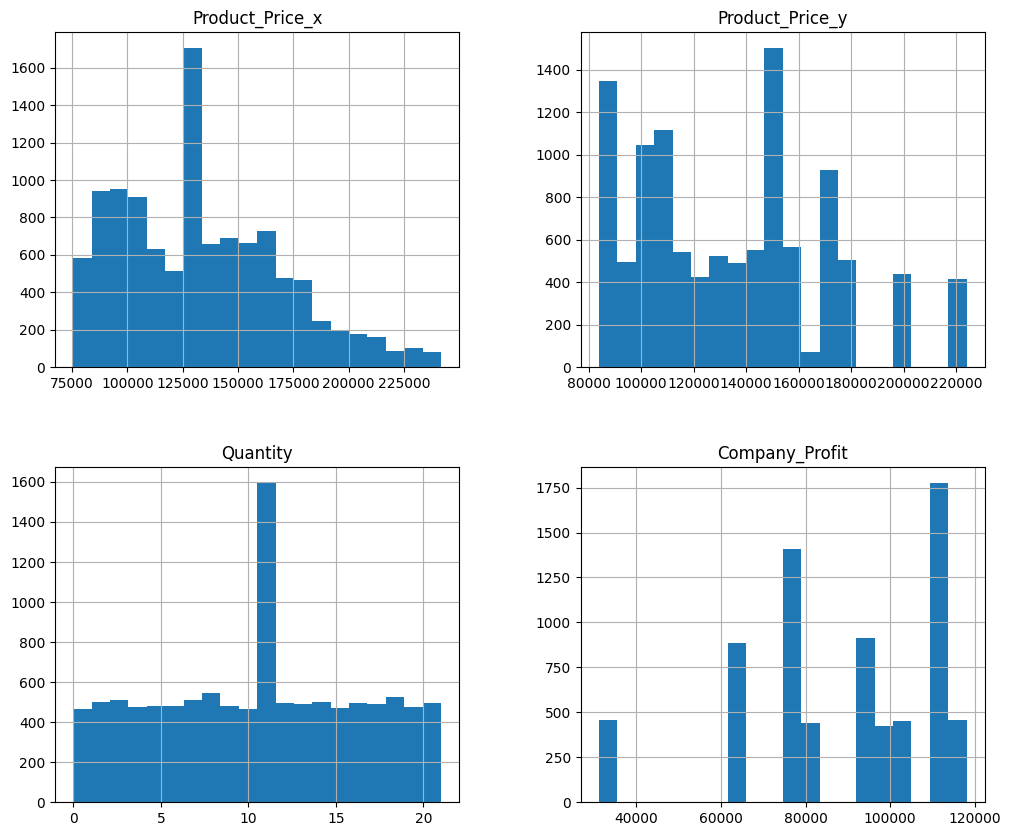

In [403]:
# EDA
# Histograms for numerical data
final_merged_data[['Product_Price_x', 'Product_Price_y', 'Quantity', 'Company_Profit']].hist(bins=20, figsize=(12, 10))
plt.show()

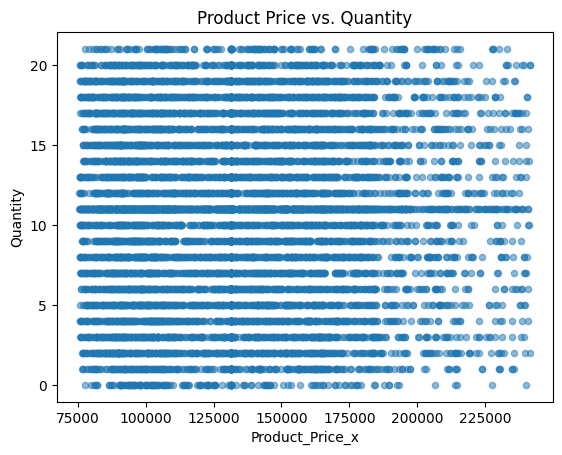

In [404]:
# Scatter plot to check relationships between features
final_merged_data.plot.scatter(x='Product_Price_x', y='Quantity', alpha=0.5)
plt.title('Product Price vs. Quantity')
plt.show()

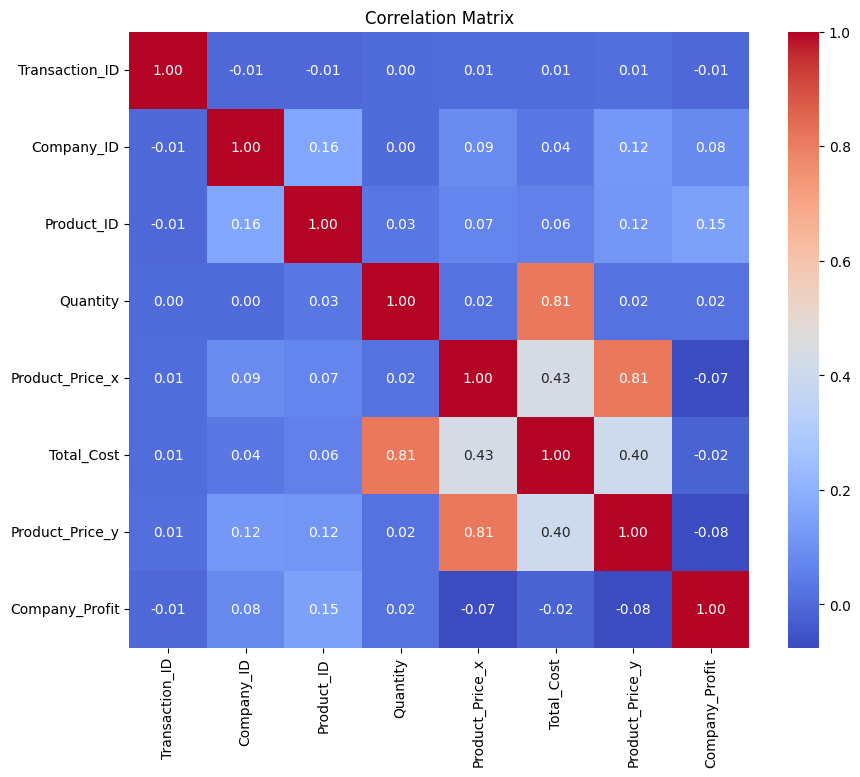

In [405]:
# Correlation Matrix: To explore relationships between columns
# Select only numeric columns for correlation calculation
numeric_data = final_merged_data.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

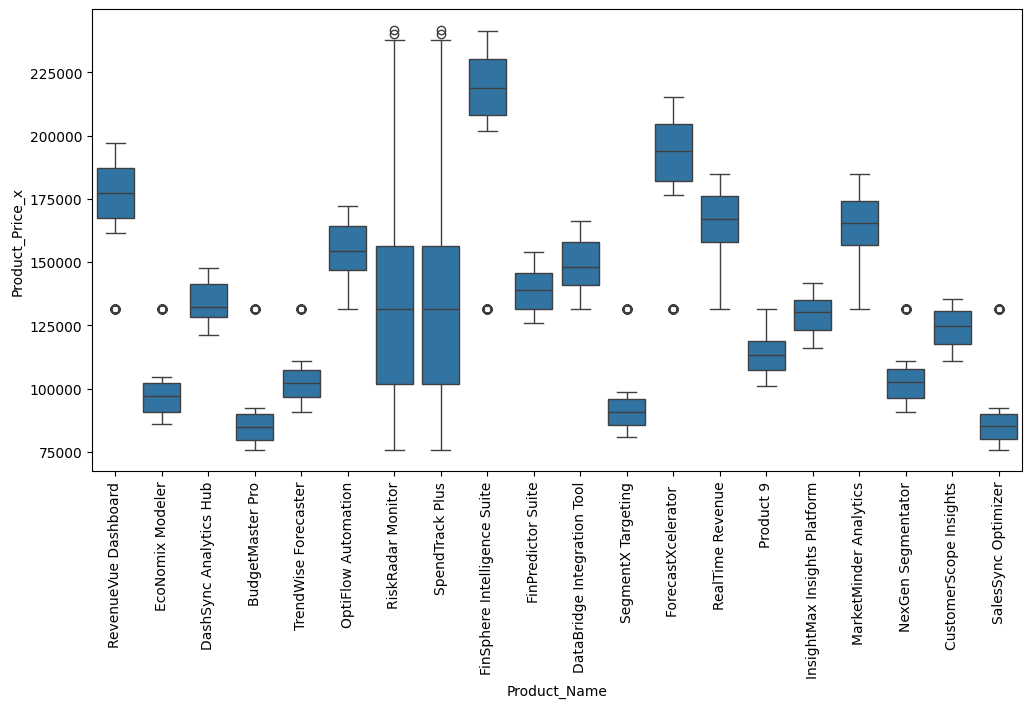

In [406]:
# Box plots to visualize spread and outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='Product_Name', y='Product_Price_x', data=final_merged_data)
plt.xticks(rotation=90)
plt.show()

In [407]:
# Ensure 'Transaction_Date' is in datetime format
final_merged_data['Transaction_Date'] = pd.to_datetime(final_merged_data['Transaction_Date'], errors='coerce')

# Extract features from 'Transaction_Date' (year, month, day, weekday)
final_merged_data['Transaction_Year'] = final_merged_data['Transaction_Date'].dt.year
final_merged_data['Transaction_Month'] = final_merged_data['Transaction_Date'].dt.month
final_merged_data['Transaction_Day'] = final_merged_data['Transaction_Date'].dt.day
final_merged_data['Transaction_Weekday'] = final_merged_data['Transaction_Date'].dt.weekday  # 0=Monday, 6=Sunday

# Drop 'Transaction_Date' column, as it's no longer needed
final_merged_data = final_merged_data.drop(columns=['Transaction_Date'])

# Check if all the new columns are numeric
print(final_merged_data[['Transaction_Year', 'Transaction_Month', 'Transaction_Day', 'Transaction_Weekday']].head())

   Transaction_Year  Transaction_Month  Transaction_Day  Transaction_Weekday
0              2024                  3               26                    1
1              2024                  7                9                    1
2              2024                  4               13                    5
3              2023                  6                9                    4
4              2021                  6                7                    0


In [408]:
# Ensure the Total_Profit column is correctly created
final_merged_data['Total_Profit'] = final_merged_data['Quantity'] * final_merged_data['Company_Profit']

# Check Column Names
print(final_merged_data.columns)

Index(['Transaction_ID', 'Company_ID', 'Product_ID', 'Quantity',
       'Product_Price_x', 'Total_Cost', 'Product_Name', 'Product_Price_y',
       'Company_Name', 'Company_Profit', 'Address', 'Transaction_Year',
       'Transaction_Month', 'Transaction_Day', 'Transaction_Weekday',
       'Total_Profit'],
      dtype='object')


In [446]:
# Check for non-numeric values in the dataset
non_numeric_rows = final_merged_data.apply(pd.to_numeric, errors='coerce').isna().sum()
print("Non-numeric values count per column:")
print(non_numeric_rows)

Non-numeric values count per column:
Transaction_ID              0
Company_ID                  0
Product_ID                  0
Quantity                    0
Product_Price_x             0
Total_Cost                  0
Product_Price_y             0
Company_Name            10960
Company_Profit              0
Address                 10960
Transaction_Year            0
Transaction_Month           0
Transaction_Day             0
Transaction_Weekday         0
Total_Profit                0
Product_Name_encoded        0
dtype: int64


In [447]:
# Instantiate the label encoder
label_encoder = LabelEncoder()

# Apply LabelEncoder on 'Company_Name' and 'Address' columns
final_merged_data['Company_Name_encoded'] = label_encoder.fit_transform(final_merged_data['Company_Name'])
final_merged_data['Address_encoded'] = label_encoder.fit_transform(final_merged_data['Address'])

# Drop the original 'Company_Name' and 'Address' columns
final_merged_data = final_merged_data.drop(columns=['Company_Name', 'Address'])

# Verify the changes
print(final_merged_data.head())

   Transaction_ID  Company_ID  Product_ID  Quantity  Product_Price_x  \
0               1          88           6        11        194379.15   
1               2          29          19        16         97930.99   
2           10000          28          18         6        126095.55   
3               4          85          12        12        131297.78   
4               5          47           3         8         99575.61   

   Total_Cost  Product_Price_y  Company_Profit  Transaction_Year  \
0   1075200.0         179200.0    75950.000000              2024   
1   1428000.0          95200.0    61952.000000              2024   
2    940800.0         134400.0    88601.519313              2024   
3   1008000.0          84000.0   113470.000000              2023   
4    705600.0         100800.0    31130.000000              2021   

   Transaction_Month  Transaction_Day  Transaction_Weekday  Total_Profit  \
0                  3               26                    1     835450.00   
1     

In [449]:
# Check for non-numeric values in the dataset
non_numeric_rows = final_merged_data[final_merged_data['Product_Name_encoded'].apply(pd.to_numeric, errors='coerce').isna()]
print(non_numeric_rows)

Empty DataFrame
Columns: [Transaction_ID, Company_ID, Product_ID, Quantity, Product_Price_x, Total_Cost, Product_Price_y, Company_Profit, Transaction_Year, Transaction_Month, Transaction_Day, Transaction_Weekday, Total_Profit, Product_Name_encoded, Company_Name_encoded, Address_encoded]
Index: []


In [450]:
# Fill missing values in 'Quantity' and 'Company_Profit' (without inplace=True)
final_merged_data = final_merged_data.assign(
    Quantity = final_merged_data['Quantity'].fillna(final_merged_data['Quantity'].median()),  # Fill 'Quantity' with median
    Company_Profit = final_merged_data['Company_Profit'].fillna(final_merged_data['Company_Profit'].mean())  # Fill 'Company_Profit' with mean
)

# Recalculate 'Total_Profit' after filling missing values
final_merged_data['Total_Profit'] = final_merged_data['Quantity'] * final_merged_data['Company_Profit']

# Round 'Total_Profit' to two decimal places
final_merged_data['Total_Profit'] = final_merged_data['Total_Profit'].round(2)

# Check if the missing values are filled correctly
print(final_merged_data[['Quantity', 'Company_Profit', 'Total_Profit']].head())

   Quantity  Company_Profit  Total_Profit
0        11    75950.000000     835450.00
1        16    61952.000000     991232.00
2         6    88601.519313     531609.12
3        12   113470.000000    1361640.00
4         8    31130.000000     249040.00


In [451]:
# Confirm all columns are numeric
print(final_merged_data.dtypes)

Transaction_ID            int64
Company_ID                int64
Product_ID                int64
Quantity                  int64
Product_Price_x         float64
Total_Cost              float64
Product_Price_y         float64
Company_Profit          float64
Transaction_Year          int32
Transaction_Month         int32
Transaction_Day           int32
Transaction_Weekday       int32
Total_Profit            float64
Product_Name_encoded      int64
Company_Name_encoded      int64
Address_encoded           int64
dtype: object


In [452]:
# 'Total_Profit' is the target variable, and other columns are features
X = final_merged_data.drop(['Total_Profit'], axis=1)  # Drop the target column
y = final_merged_data['Total_Profit']  # This is the target

# Split data into training and testing sets (80% training, 20% testing)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shape of the split data
print(f"Training Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training Data Shape: X_train: (8768, 15), y_train: (8768,)
Testing Data Shape: X_test: (2192, 15), y_test: (2192,)


In [454]:
# Instantiate the model (Random Forest Regressor)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [455]:
# Instantiate the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared value

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 371206.5304027165
R-squared: 0.9999987628737702
